## Homework 06: Optimization in Python

## Due Date: April 10, 2024, 6:00pm

#### Firstname Lastname: Jiasheng Ni

#### E-mail: jn2294@nyu.edu

#### Enter your solutions and submit this notebook

---

**Problem 1 (30p)**

We examine a product of non-negative numbers given their sum. Concretely, the problem is to find all $(x, y, z)$ among all non-negative reals $x, y, z \geq 0$ such that
their product $P(x, y, z) = x y z$ is maximized, given their sum $x + y + z = 270$. 


1.1. (15p)
Cast the problem as a nonlinear two-dimensional optimization problem over with box constraints (*hint*: remove the sum constraint, and ignore one of the positivity constraints which should not be violated with proper initialization) and solve it using the L-BFGS-B method of `scipy.optimize.minimize`.

1.2. (15p)
Cast the problem as an equivalent one-dimensional constrained optimization problem (*hint*: after removing the sum constraint, can you further use optimality conditions to remove one more variable?), and solve it using `scipy.optimize.minimize_scalar`.



# Problem 1 Reparametrization
**Two dimensional equivalent**: Suppose we substitute $z$ with $f(x,y)$ such that $z = 270-x-y$ where $x+y<=270$. Since $x,y\geq 0$, we have $0\leq x, y\leq 270$, which is a box constraint.
Now that the optimization problem can be casted as:
$$min_{x,y} f(x,y)=xy(270-x-y)$$ s.t. $$ x,y\geq 0, 0\leq x+y\leq 270$$

**One dimensional equivalent**: We could first use $P(x,y,z)=f(x,y)=xy(270-x-y)$ and take teh partial derivatives:
$$\begin{cases} \frac{\partial f}{\partial x}&=270y-x^2y-y^2=0\\\frac{\partial f}{\partial y}&=270x-2xy-y^2=0\end{cases}$$
and solve to get $x+y=270$ or $x=y$.

The former one leads to $P(x,y,z)=0$ which is not global maximum, so we opt for the latter, which leads to:
$$min_x f(x)=270x^2 - 2x^3$$ s.t. $$0\leq x\leq 135$$

In [27]:
# 1.1
from scipy.optimize import minimize
import numpy as np

def opt_func_two_dim(x):
    # Given x and y, calculate z using the sum constraint: z = 270 - x - y
    z = 270 - np.sum(x)
    return -(x[0] * x[1] * z)  # We return the negative since we are minimizing

# Box constraints for x and y
c = [(0, 270), (0, 270)]

# Initial values
x0 = [90, 90]

# Solve using the L-BFGS-B method
result = minimize(opt_func_two_dim, x0, bounds=c, method='L-BFGS-B')

# Get the optimized values of x, y, and z
x_opt, y_opt = result.x
z_opt = 270 - x_opt - y_opt
product_optimized = -result.fun  # Multiply by -1 because we minimized the negative

if result.success:
    print(f'Optimized values are x={x_opt}, y={y_opt}, z={z_opt} with the product={product_optimized}')
else:
    print('Optimization failed.')


Optimized values are x=89.99999955075118, y=89.99999955075118, z=90.00000089849765 with the product=729000.0


In [30]:
# 1.2
from scipy.optimize import minimize_scalar
def opt_func_one_dim(x):
    return - (270 * np.power(x, 2) - 2 * np.power(x, 3))


# Box constraints for x and y
bounds = (0, 135)

# Initial values
x0 = [25]

# Solve using the L-BFGS-B method
result = minimize_scalar(opt_func_one_dim, x0, bounds=bounds, method='bounded')

# Get the optimized values of x, y, and z
x_opt = result.x
y_opt = x_opt
z_opt = 270 - x_opt - y_opt
product_optimized = -result.fun  # Multiply by -1 because we minimized the negative

if result.success:
    print(f'Optimized values are x={x_opt}, y={y_opt}, z={z_opt} with the product={product_optimized}')
else:
    print('Optimization failed.')


Optimized values are x=90.00000033137091, y=90.00000033137091, z=89.99999933725816 with the product=729000.0


---

**Problem 2 (70p)**

Let us consider the following function,

$$h(x, y) := (x^2 + y - 10)^2 + (x + y^2 - 17)^2.$$
    
find **all extremal** points (both minima and maxima) in the region $-10 \leq x, y \leq 10$.


The goal is to: (a) find extremal points; (b) compare convergence, i.e. the numbers of: Iterations, Function evaluations, Gradient evaluations, Hessian evaluations.


Solve the problem by using the Newton optimization routine "scipy.optimize.fmin_ncg":

2.1. (20p) providing gradient (fprime) and Hessian (fhess) in "scipy.optimize.fmin_ncg"

2.2. (20p) providing only gradient (fprime) in "scipy.optimize.fmin_ncg"

Solve the problem by using the quasi-Newton optimization routine "fmin_bfgs":

2.3. (20p) **not** providing gradient (fprime) or Hessian (like in "scipy.optimize.fmin_ncg").


Use JAX for computing the gradient and Hessian as in the lecture. (make sure the gradient and Hessian are correctly computed).


2.4. (10p) Plot $h(x, y)$ in the given region $-10 \leq x, y \leq 10$.


**Hint**: Note there are multiple extremal points in the given region. So one has to run the Newton routine with different starting points in order to find different extremal points. 


For every extremal point report: 
- (xopt, yopt)
- h(xopt, yopt)
- (xstart, ystart)
- the number of Iterations
- the number of Function evaluations
- the number of Gradient evaluations
- the number of Hessian evaluations.

**Hint 2:** There are both local mimima and maxima; notice that "scipy.optimize.fmin_ncg" finds "minimum" not the "maximum". To locate stationary points, partition $-10 \leq x, y \leq 10$ into multiple regions and use "optimize.brute" in each of these regions. Then use the resulting points as starting points in "scipy.optimize.fmin_ncg".


In [98]:
# Helper functions
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):
    _x = x[0]
    _y = x[1]

    return (_x ** 2 + _y - 10) ** 2 + (_x + _y ** 2 - 17) ** 2


def fprime(x):
    _x = x[0]
    _y = x[1]

    return np.array([2 * (_x ** 2 + _y - 10) * 2 * _x + 2 * (_x + _y ** 2 - 17)
                    ,2 * (_x ** 2 + _y - 10) + 2 * (_x + _y ** 2 - 17) * 2 * _y])


def fhess(x):
    _x = x[0]
    _y = x[1]

    return np.array([[12 * _x ** 2 - 18, 4 * _x + 4 * _y], [4 * _x + 4 * _y, 12 * _y ** 2 - 66]])

# 2.4 Helper function
def plot_extremal(obj_func, x_starts, opt_alg, **kwargs):

    fig, axes = plt.subplots(3,3, figsize=(20, 15))
    x1 = x2 = np.linspace(-6, 6, 100)
    X1, X2 = np.meshgrid(x1, x2)

    fprime = kwargs["fprime"]
    fhess = kwargs["fhess"]

    is_fprime = kwargs["activate_fprime"]
    is_fhess = kwargs["activate_fhess"]

    for i in range(3):
        for j in range(3):
            ax = axes[i,j]
            x_start = x_starts[i * 3 + j]
            if is_fprime and is_fhess:
                xopt, fopt, fcalls, gcalls, hcalls, warnflag, allvecs = opt_alg(obj_func, x_start, fprime=fprime, fhess=fhess, full_output = True, disp = False, retall = True)
            elif is_fprime:
                xopt, fopt, fcalls, gcalls, hcalls, warnflag, allvecs = opt_alg(obj_func, x_start, fprime=fprime, full_output = True, disp = False, retall = True)
            else:
                assert opt_alg == fmin_bfgs

                xopt, fopt, gopt, Bopt, fcalls, gcalls, warnflag, allvecs = opt_alg(obj_func, x_start, full_output = True, disp = False, retall = True)

            print(f"----------Test Starting Point 1 ({x_start[0], x_start[1]})------------")
            print(f"(xopt, yopt): ({xopt[0], xopt[1]})")
            print(f"f(xopt, yopt): {fopt}")
            print(f"(xstart, ystart): {x_start[0], x_start[1]}")
            print(f"Number of iterations: {len(allvecs)}")
            print(f"Number of function evaluations: {fcalls}")
            print(f"Number of gradient evaluations: {gcalls}")
            if is_fprime or is_fhess:
                hcalls = "Not displayable"
                print(f"Number of hessian evaluations: {hcalls}")
            ax.plot(xopt[0], xopt[1], 'r*', markersize=15, label="extremal point")
            ax.plot(x_start[0], x_start[1], 'b*', markersize=15, label="starting point")
            ax.contour(X1, X2, f((X1, X2)), 50)
            ax.set_xlabel(r"$x_1$", fontsize=18)
            ax.set_ylabel(r"$x_2$", fontsize=18)
            plt.colorbar(c, ax=ax)
            ax.legend()

# Starting points
start = np.linspace(-4, 4, 3)
_x, _y = np.meshgrid(start, start)
x_starts = list(zip(_x.flatten(), _y.flatten()))

----------Test Starting Point 1 ((-4.0, -4.0))------------
(xopt, yopt): ((-3.8160780511345123, -4.562463772471802))
f(xopt, yopt): 1.5157478498514271e-10
(xstart, ystart): (-4.0, -4.0)
Number of iterations: 10
Number of function evaluations: 10
Number of gradient evaluations: 10
Number of hessian evaluations: 9
----------Test Starting Point 1 ((0.0, -4.0))------------
(xopt, yopt): ((3.6942794037620112, -3.647698133362654))
f(xopt, yopt): 3.6287266483066614e-10
(xstart, ystart): (0.0, -4.0)
Number of iterations: 7
Number of function evaluations: 12
Number of gradient evaluations: 12
Number of hessian evaluations: 6
----------Test Starting Point 1 ((4.0, -4.0))------------
(xopt, yopt): ((3.6942792965807385, -3.64770024621961))
f(xopt, yopt): 1.3609497486632698e-11
(xstart, ystart): (4.0, -4.0)
Number of iterations: 7
Number of function evaluations: 7
Number of gradient evaluations: 7
Number of hessian evaluations: 6
----------Test Starting Point 1 ((-4.0, 0.0))------------
(xopt, yopt

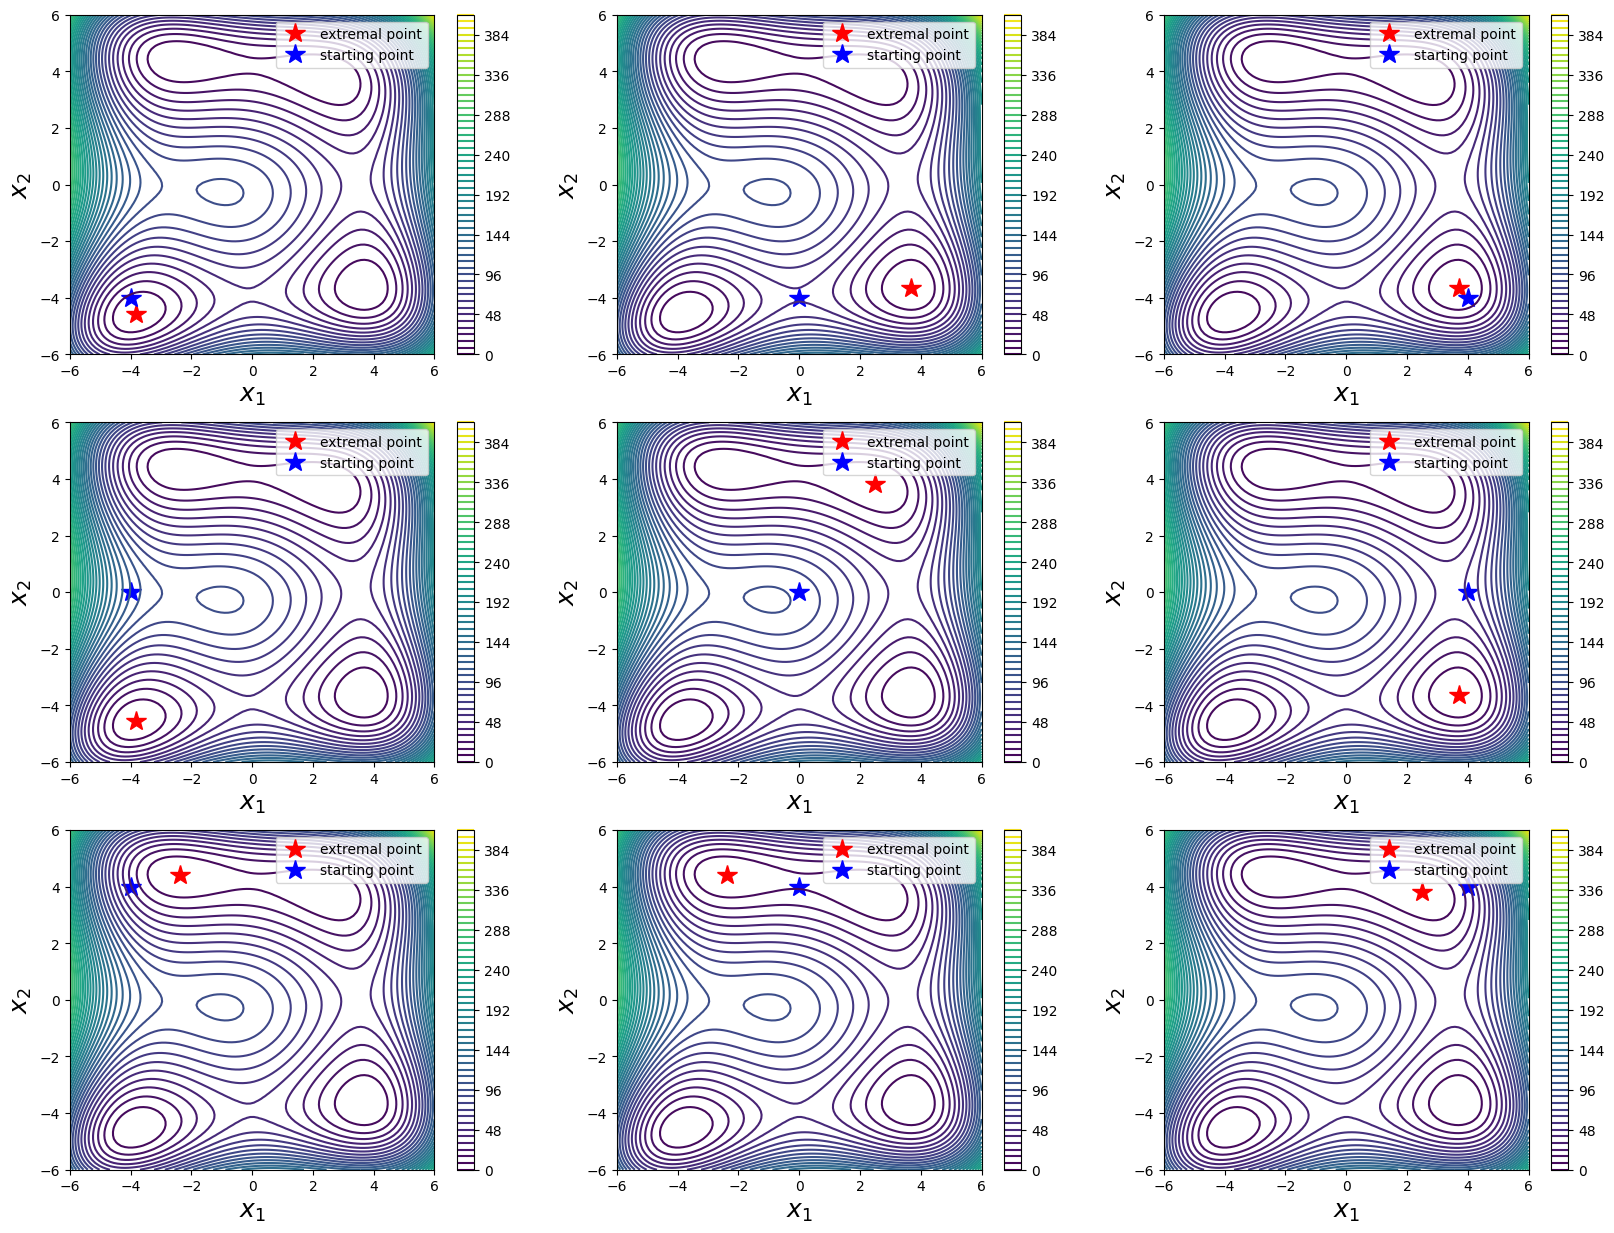

In [96]:
# 2.1 Newton's Method(with Jacobian and Hessian)
from scipy.optimize import fmin_ncg, fmin_bfgs
import numpy as np

opt_param = {"fprime": fprime, "fhess": fhess, "activate_fprime": True, "activate_fhess": True}
plot_extremal(f, x_starts, fmin_ncg, **opt_param)

----------Test Starting Point 1 ((-4.0, -4.0))------------
(xopt, yopt): ((-3.816079691898772, -4.5624642125954775))
f(xopt, yopt): 5.88202867981883e-18
(xstart, ystart): (-4.0, -4.0)
Number of iterations: 9
Number of function evaluations: 9
Number of gradient evaluations: 22
Number of hessian evaluations: 0

----------Test Starting Point 1 ((0.0, -4.0))------------
(xopt, yopt): ((3.694279431503179, -3.6477008076084276))
f(xopt, yopt): 4.600312654071457e-13
(xstart, ystart): (0.0, -4.0)
Number of iterations: 7
Number of function evaluations: 12
Number of gradient evaluations: 18
Number of hessian evaluations: 0

----------Test Starting Point 1 ((4.0, -4.0))------------
(xopt, yopt): ((3.69427946272248, -3.647700728496158))
f(xopt, yopt): 4.949851509926961e-15
(xstart, ystart): (4.0, -4.0)
Number of iterations: 5
Number of function evaluations: 5
Number of gradient evaluations: 9
Number of hessian evaluations: 0

----------Test Starting Point 1 ((-4.0, 0.0))------------
(xopt, yopt): (

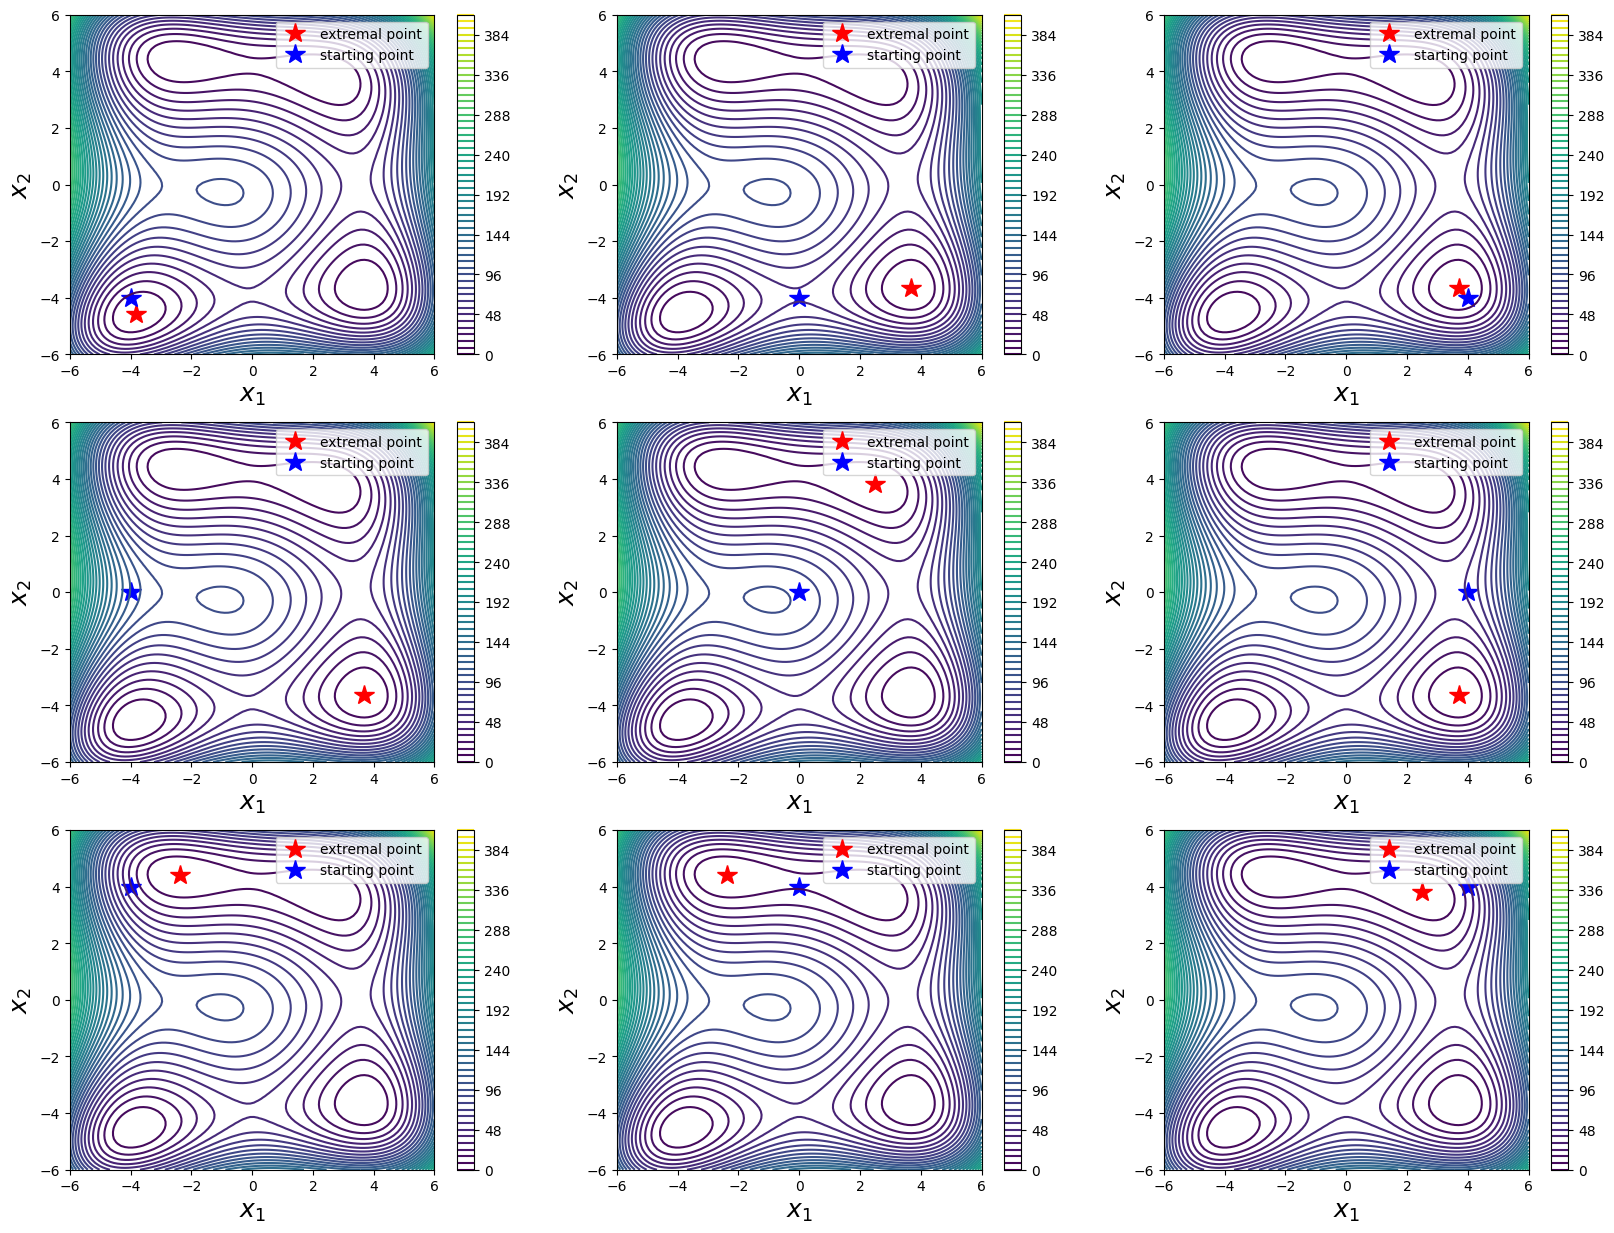

In [94]:
# 2.2
opt_param = {"fprime": fprime, "fhess": fhess, "activate_fprime": True, "activate_fhess": False}
plot_extremal(f, x_starts, fmin_ncg, **opt_param)

In [5]:
!pip install jax
!pip install jaxlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


----------Test Starting Point 1 ((-4.0, -4.0))------------
(xopt, yopt): ((-3.816079703820268, -4.562464213539917))
f(xopt, yopt): 8.547947882718288e-15
(xstart, ystart): (-4.0, -4.0)
Number of iterations: 9
Number of function evaluations: 30
Number of gradient evaluations: 10
----------Test Starting Point 1 ((0.0, -4.0))------------
(xopt, yopt): ((3.6942794515568327, -3.647700726675255))
f(xopt, yopt): 5.5020433953684745e-15
(xstart, ystart): (0.0, -4.0)
Number of iterations: 12
Number of function evaluations: 66
Number of gradient evaluations: 22
----------Test Starting Point 1 ((4.0, -4.0))------------
(xopt, yopt): ((3.6942794521175335, -3.6477007283905603))
f(xopt, yopt): 6.508199075364115e-15
(xstart, ystart): (4.0, -4.0)
Number of iterations: 5
Number of function evaluations: 21
Number of gradient evaluations: 7
----------Test Starting Point 1 ((-4.0, 0.0))------------
(xopt, yopt): ((-3.8160796970974857, -4.562464182189808))
f(xopt, yopt): 8.552052750251421e-14
(xstart, ystart

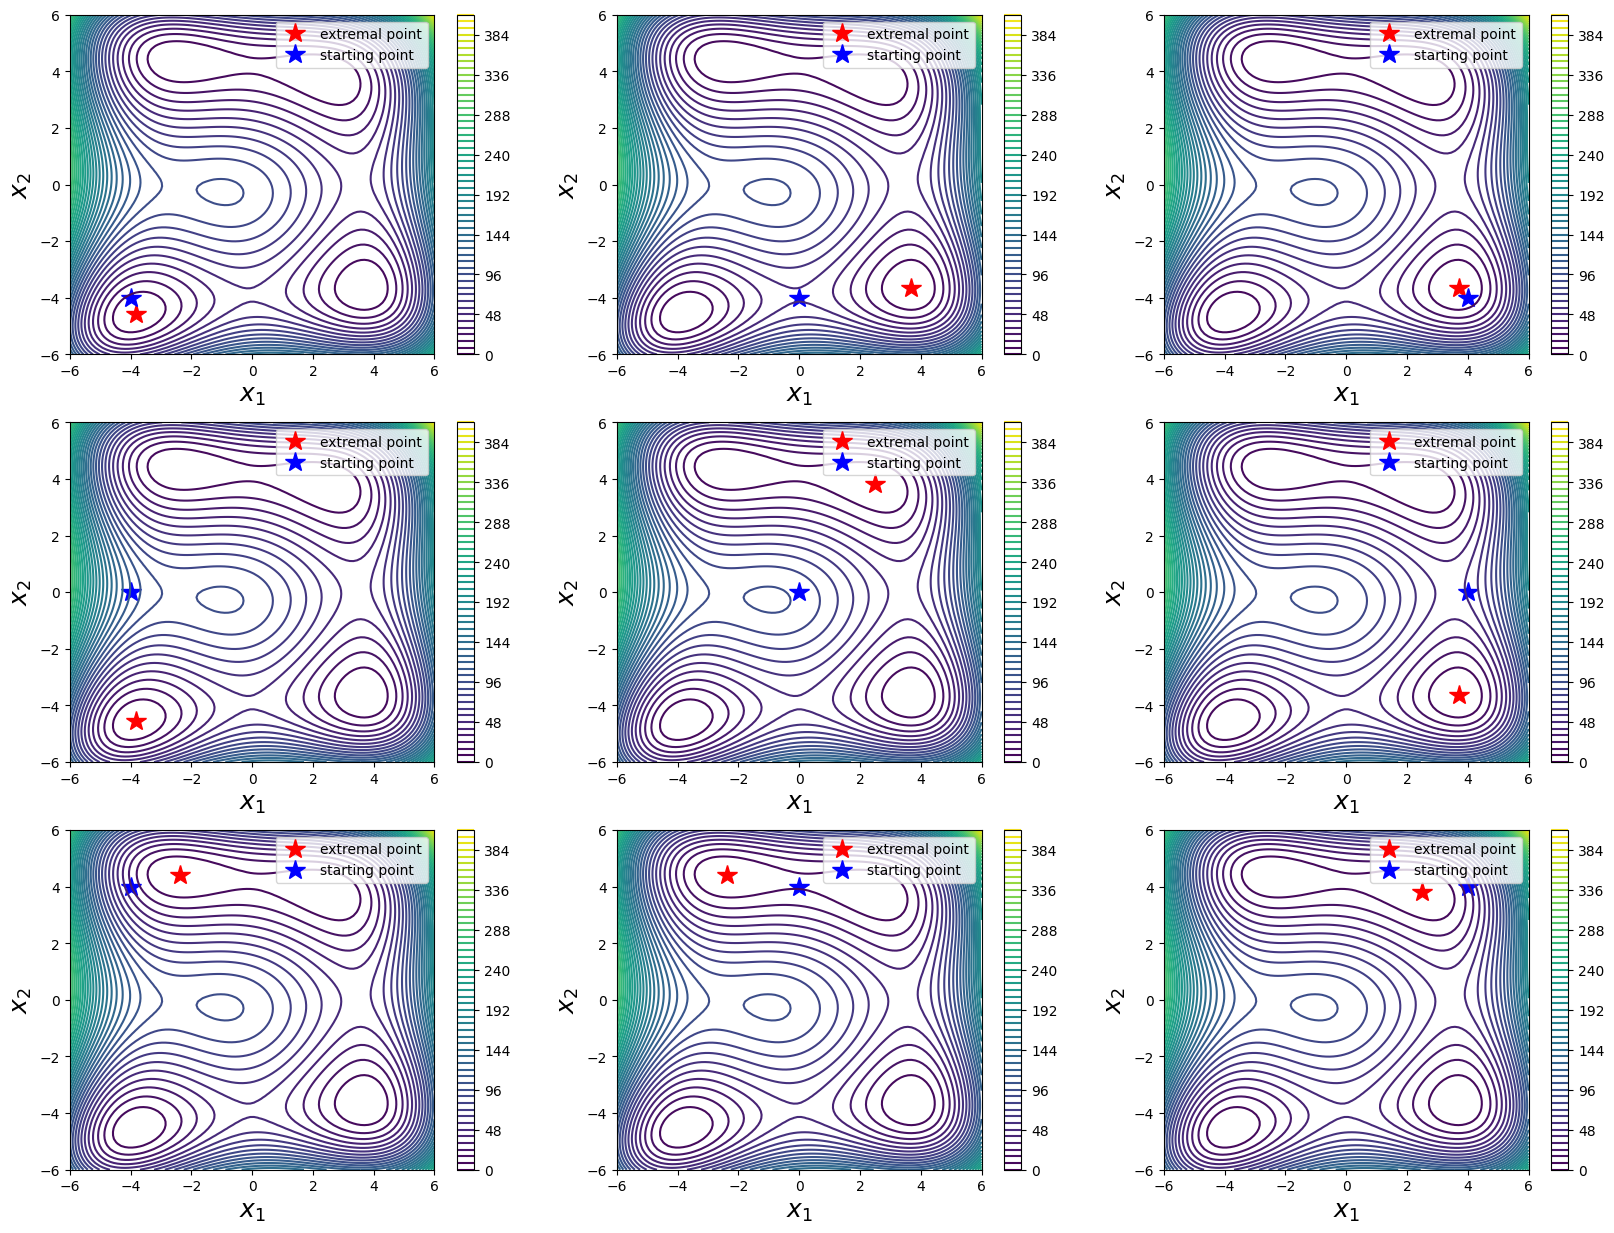

In [100]:
# 2.3
import jax.numpy as jnp
from jax import jit, grad, hessian
import scipy.optimize as opt

ff = jit(f)
ffprime = jit(grad(f))
ffhess = jit(hessian(f))

opt_param = {"fprime": fprime, "fhess": fhess, "activate_fprime": False, "activate_fhess": False}
plot_extremal(f, x_starts, fmin_bfgs, **opt_param)